# Library Imports

In [7]:
import pandas as pd
import glob
import requests
import time

In [8]:
import seaborn as sns

# How to get the data? and which data I'm using?

<div style="float: left">
<img style="float: right" src="datasets/privacy_page.jpg" alt="screenshot" width="600"/>
Good question! I actually just found this out recently myself that you can request your streaming data from Spotify! 

The process is quite simple, All you need to do is to access [your account's privace page](https://www.spotify.com/us/account/privacy/) , put a tick on the data that you want to request from spotify (see the screenshot on the right)

The data I'm using in this project is the streaming hisotry (from Extended Streaming History option) where it consists of multiple .json files of your spotify streaming history (for both music and podcasts)
I chose the Extended Streaming History because the data includes your entire lifetime of your account, and it also includes _spotify_track_uri_, a unique identifier for each spotify tracks that we can use to collect even more information about the tracks (such as audio features, track info, etc) using [Spotify Web API](https://developer.spotify.com/) later.

Account Data only conists of one-year length of data and it does not have the _spotify_track_uri_ information, technically you can still collect the tracks' info, audio features data using only artists' name and tracks' name but it adds more work and can be quite unreliable (plus, extended streaming history gives you MORE data, so why not?)

Based on my experience, it took about 10 days to receive the Account Data and about 3 weeks to get Extended Streaming History from the time I requested the data.
</div>


# Data Imports / Exports

In [23]:
# THESE FILES ARE EXCLUDED FROM THE REPOSITORY
stream_json = glob.glob('datasets/v2/Streaming_History_Audio*.json')

In [24]:
# see the list of globbed files
stream_json

['datasets/v2\\Streaming_History_Audio_2016-2017_0.json',
 'datasets/v2\\Streaming_History_Audio_2017-2018_1.json',
 'datasets/v2\\Streaming_History_Audio_2018-2019_2.json',
 'datasets/v2\\Streaming_History_Audio_2019-2020_3.json',
 'datasets/v2\\Streaming_History_Audio_2020-2021_4.json',
 'datasets/v2\\Streaming_History_Audio_2021-2022_5.json',
 'datasets/v2\\Streaming_History_Audio_2022-2023_6.json',
 'datasets/v2\\Streaming_History_Audio_2023_7.json',
 'datasets/v2\\Streaming_History_Audio_2023_8.json']

In [25]:
# load the globbed files into a dataframe
stream_df = pd.concat([pd.read_json(f) for f in stream_json])

In [9]:
tracks_df = pd.read_csv('datasets/tracks_df.csv')
podcasts_df = pd.read_csv('datasets/podcasts_df.csv')

C:\Users\nazhi\AppData\Local\Temp\ipykernel_5344\2056156176.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  tracks_df = pd.read_csv('datasets/tracks_df.csv')


# Preparing for Data Collection
we need 4 things here.
1. tracks streaming history
2. podcasts streaming history
3. list of unique tracks streamed
4. ~~list of unique podcasts streamed~~ not really needed actually

In [26]:
print(stream_df.shape)
print(stream_df.columns)

(130209, 21)
Index(['ts', 'username', 'platform', 'ms_played', 'conn_country',
       'ip_addr_decrypted', 'user_agent_decrypted',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'reason_start',
       'reason_end', 'shuffle', 'skipped', 'offline', 'offline_timestamp',
       'incognito_mode'],
      dtype='object')


In [27]:
stream_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130209 entries, 0 to 2979
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   ts                                 130209 non-null  object
 1   username                           130209 non-null  object
 2   platform                           130209 non-null  object
 3   ms_played                          130209 non-null  int64 
 4   conn_country                       130209 non-null  object
 5   ip_addr_decrypted                  109601 non-null  object
 6   user_agent_decrypted               109601 non-null  object
 7   master_metadata_track_name         129393 non-null  object
 8   master_metadata_album_artist_name  129393 non-null  object
 9   master_metadata_album_album_name   129393 non-null  object
 10  spotify_track_uri                  129393 non-null  object
 11  episode_name                       641 non-null     object


In [28]:
# number of unique values in each column
stream_df.nunique()

ts                                   122712
username                                  1
platform                                 33
ms_played                             27030
conn_country                              9
ip_addr_decrypted                      2750
user_agent_decrypted                      6
master_metadata_track_name             4783
master_metadata_album_artist_name      1646
master_metadata_album_album_name       2700
spotify_track_uri                      5245
episode_name                            297
episode_show_name                        31
spotify_episode_uri                     297
reason_start                              8
reason_end                               10
shuffle                                   2
skipped                                   2
offline                                   2
offline_timestamp                    128332
incognito_mode                            2
dtype: int64

In [29]:
stream_df.isna().sum()

ts                                        0
username                                  0
platform                                  0
ms_played                                 0
conn_country                              0
ip_addr_decrypted                     20608
user_agent_decrypted                  20608
master_metadata_track_name              816
master_metadata_album_artist_name       816
master_metadata_album_album_name        816
spotify_track_uri                       816
episode_name                         129568
episode_show_name                    129568
spotify_episode_uri                  129568
reason_start                              0
reason_end                            20608
shuffle                                   0
skipped                              106195
offline                                   0
offline_timestamp                         0
incognito_mode                            0
dtype: int64

In [30]:
stream_df['user_agent_decrypted'].value_counts()

user_agent_decrypted
unknown                                                                                                                                                                  109525
Mozilla%2F5.0%20(Windows%20NT%2010.0;%20Win64;%20x64)%20AppleWebKit%2F537.36%20(KHTML,%20like%20Gecko)%20Chrome%2F95.0.4638.54%20Safari%2F537.36%20Edg%2F95.0.1020.40        66
Mozilla%2F5.0%20(Windows%20NT%2010.0;%20Win64;%20x64;%20rv:84.0)%20Gecko%2F20100101%20Firefox%2F84.0                                                                          6
Mozilla%2F5.0%20(Windows%20NT%2010.0;%20Win64;%20x64;%20rv:61.0)%20Gecko%2F20100101%20Firefox%2F61.0                                                                          2
Mozilla%2F5.0%20(Windows%20NT%2010.0;%20Win64;%20x64;%20rv:69.0)%20Gecko%2F20100101%20Firefox%2F69.0                                                                          1
Mozilla%2F5.0%20(Windows%20NT%2010.0;%20Win64;%20x64;%20rv:83.0)%20Gecko%2F20100101%20Firefox%2F83.

In [31]:
# dropping some columns that might cnotain sensitive information or just not useful
stream_df.drop(columns=['username', 'ip_addr_decrypted', 'user_agent_decrypted'], inplace=True)

there are a huge number of null value of 'spotify_episode_uri', indicating that tracks/songs and podcasts don't share same uri, we need to separate this into its own dataframe (for tracks and podcasts)

In [32]:
# rows with null in both spotify_track_uri and spotify_episode_uri
print(stream_df[stream_df['spotify_episode_uri'].isna() & stream_df['spotify_track_uri'].isna()].shape)
print(stream_df[stream_df['spotify_episode_uri'].notna() & stream_df['spotify_track_uri'].notna()].shape)

(175, 18)
(0, 18)


so apparently there exists some rows are null on both spotify_episode_uri and spotify_track_uri, so those should be excluded as well

In [33]:
# get rows with null values in 'spotify_episode_uri' column and put it into a new dataframe
tracks_df = stream_df[stream_df['spotify_track_uri'].notna()]
podcasts_df = stream_df[stream_df['spotify_episode_uri'].notna()]

In [34]:
print(tracks_df.shape)
print(podcasts_df.shape)

(129393, 18)
(641, 18)


In [10]:
# list of tracks, containing unique values in 'spotify_track_uri' column
tracks_uri_list = tracks_df['spotify_track_uri'].unique().tolist()
podcasts_uri_list = podcasts_df['spotify_episode_uri'].unique().tolist()

In [11]:
print(len(tracks_uri_list))
print(len(podcasts_uri_list))

5245
297


In [37]:
# save tracks_df and podcasts_df into csv
tracks_df.to_csv('datasets/tracks_df.csv', index=False)
podcasts_df.to_csv('datasets/podcasts_df.csv', index=False)

# Data Collection (Spotipy)
now we're going to collect the using [Spotipy](https://spotipy.readthedocs.io/en/2.22.1/), it'll require user credentials (client_id and client_secret) which you can get [here](https://developer.spotify.com/dashboard) by registering your app at the dashboard

In [4]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
# Spotify API credentials (client_id and client_secret used will be excluded from the repository)
client_id = 'YOUR CLIENT ID'
client_secret = 'YOUR CLIENT SECRET'

In [5]:
#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

## get track info

In [12]:
# since they have the batch request limit of 50, we need to split the list into batches of 50
track_info = {}
for i in range(0, len(tracks_uri_list), 50):
    track_batch = tracks_uri_list[i:i+50]
    sapi = sp.tracks(track_batch)
    for track in sapi['tracks']:
        track_info[track['id']] = {'name':track['name'], 'artistName':track['artists'][0]['name'], 'release_date':track['album']['release_date'], 'popularity':track['popularity'], 'duration_ms':track['duration_ms'], 'isrc':track['external_ids'].get('isrc', None)}
    time.sleep(1)
    

In [6]:
sp.track('6tAM5c0bJOwRqGAEgiNMpI')

{'album': {'album_type': 'compilation',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0LyfQWJT6nXafLPZqxe9Of'},
    'href': 'https://api.spotify.com/v1/artists/0LyfQWJT6nXafLPZqxe9Of',
    'id': '0LyfQWJT6nXafLPZqxe9Of',
    'name': 'Various Artists',
    'type': 'artist',
    'uri': 'spotify:artist:0LyfQWJT6nXafLPZqxe9Of'}],
  'available_markets': [],
  'external_urls': {'spotify': 'https://open.spotify.com/album/7dArkHuO5wkus2TJTu6Ytx'},
  'href': 'https://api.spotify.com/v1/albums/7dArkHuO5wkus2TJTu6Ytx',
  'id': '7dArkHuO5wkus2TJTu6Ytx',
  'images': [{'url': 'https://i.scdn.co/image/ab67616d0000b273da7770b79a66bc42de93d8e7',
    'width': 640,
    'height': 640},
   {'url': 'https://i.scdn.co/image/ab67616d00001e02da7770b79a66bc42de93d8e7',
    'width': 300,
    'height': 300},
   {'url': 'https://i.scdn.co/image/ab67616d00004851da7770b79a66bc42de93d8e7',
    'width': 64,
    'height': 64}],
  'name': 'Monstercat 007 - Solace',
  'release_date': '2012-

In [13]:
len(track_info)

5245

In [14]:
list(track_info.items())[:5]

[('6tAM5c0bJOwRqGAEgiNMpI',
  {'name': 'Solace Album Mix',
   'artistName': 'Monstercat',
   'release_date': '2012-06-06',
   'popularity': 0,
   'duration_ms': 3538579,
   'isrc': 'TCABG1284815'}),
 ('4mjgNE8R31AzxWfPNGtVMf',
  {'name': 'Best of 2015 (Album Mix)',
   'artistName': 'Monstercat',
   'release_date': '2016-01-22',
   'popularity': 0,
   'duration_ms': 9158194,
   'isrc': 'CA6D21600007'}),
 ('5Q0P0cX3e42PgKd8LLS3ms',
  {'name': 'Horizon Album Mix',
   'artistName': 'Monstercat',
   'release_date': '2014-08-06',
   'popularity': 0,
   'duration_ms': 3623121,
   'isrc': 'TCABY1492585'}),
 ('6jvMmRtSzoEibQGrQkSISQ',
  {'name': 'Monstercat Best of 2012',
   'artistName': 'Monstercat',
   'release_date': '2013-02-04',
   'popularity': 0,
   'duration_ms': 6348017,
   'isrc': 'TCABL1374362'}),
 ('1KzLyjpjIRHuuj4iX8QsC2',
  {'name': 'Monstercat Podcast EP. 100',
   'artistName': 'Monstercat',
   'release_date': '2016-04-05',
   'popularity': 0,
   'duration_ms': 9744610,
   'isrc

In [15]:
track_info_df = pd.DataFrame.from_dict(track_info, orient='index')

In [16]:
track_info_df.to_csv('datasets/tracks_info_df_isrc.csv')

In [23]:
#increase rows to display
pd.set_option('display.max_rows', 600)

In [24]:
# show rows with duplicate values in 'isrc' column
track_info_df[track_info_df['isrc'].duplicated(keep=False)].sort_values('isrc')


,name,artistName,release_date,popularity,duration_ms,isrc
15O20RQyWJgKrkHID9ynT9,Never Be Like You,Flume,2016-05-27,0,233337,AUFF01500784
5AWMbJ60z0NmztJ1Edl00K,Never Be Like You,Flume,2016-05-27,3,234909,AUFF01500784
4AP0fHeJ9MRGiS1i1xlw7Y,Real Love (feat. Danyka Nadeau),Rootkit,2014-06-30,0,275409,CA6D21000384
2GgBtBIiCiHtSFeYkUC6LU,Real Love,Rootkit,2014-06-30,27,275409,CA6D21000384
2e0TrFtmc81uvoIHR2YDaF,Breathe,Tut Tut Child,2014-10-31,28,275121,CA6D21400044
51O58Axxs6CFiJzf1uUflq,Breathe (feat. Danyka Nadeau),Tut Tut Child,2014-10-31,0,275121,CA6D21400044
5WnPPuttuxYw0jyFnQYpcp,Crossroad,Au5,2014-11-26,34,417314,CA6D21400074
1x59YtDtw7jPZTxqNYmhq2,Crossroad (feat. Danyka Nadeau),Au5,2014-12-14,0,417314,CA6D21400074
4UgecbYlUBMCq55ulRYxM0,Porta Vista,Hyper Potions,2015-04-29,27,195935,CA6D21500219
4bOBkYCCIIIp32uQYtRtAR,Porta Vista,Hyper Potions,2015-04-29,0,195935,CA6D21500219


## get track features

In [46]:
track_features = {}
for i in range(0, len(tracks_uri_list), 50):
    track_batch = tracks_uri_list[i:i+50]
    sapi = sp.audio_features(track_batch)
    for track in sapi:
        if track is not None:
            track_features[track['id']] = {'danceability':track['danceability'], 'energy':track['energy'], 'key':track['key'], 'loudness':track['loudness'], 'mode':track['mode'], 'speechiness':track['speechiness'], 'acousticness':track['acousticness'], 'instrumentalness':track['instrumentalness'], 'liveness':track['liveness'], 'valence':track['valence'], 'tempo':track['tempo'], 'time_signature':track['time_signature']}
        # we'll skip it if the track has no audio features data
    time.sleep(1)

In [47]:
len(track_features)

5238

In [48]:
# get first 5 items in the dictionary
list(track_features.items())[:5]

[('6tAM5c0bJOwRqGAEgiNMpI',
  {'danceability': 0.446,
   'energy': 0.823,
   'key': 11,
   'loudness': -5.279,
   'mode': 0,
   'speechiness': 0.0859,
   'acousticness': 0.00256,
   'instrumentalness': 0.0748,
   'liveness': 0.117,
   'valence': 0.263,
   'tempo': 128.198,
   'time_signature': 4}),
 ('5Q0P0cX3e42PgKd8LLS3ms',
  {'danceability': 0.402,
   'energy': 0.856,
   'key': 1,
   'loudness': -4.256,
   'mode': 1,
   'speechiness': 0.0659,
   'acousticness': 0.00504,
   'instrumentalness': 0.0164,
   'liveness': 0.253,
   'valence': 0.247,
   'tempo': 140.028,
   'time_signature': 4}),
 ('4VrdksXJVhAOLW49qV0VTQ',
  {'danceability': 0.426,
   'energy': 0.915,
   'key': 11,
   'loudness': -3.881,
   'mode': 0,
   'speechiness': 0.143,
   'acousticness': 0.000899,
   'instrumentalness': 0.108,
   'liveness': 0.495,
   'valence': 0.271,
   'tempo': 130.405,
   'time_signature': 4}),
 ('0ng42pTjKgskmobNzhnEUa',
  {'danceability': 0.434,
   'energy': 0.839,
   'key': 8,
   'loudness': 

In [49]:
track_features_df = pd.DataFrame.from_dict(track_features, orient='index')
track_features_df.to_csv('datasets/tracks_features_df.csv')

# Tracks Streaming Data

## Data Exploration / EDA

In [201]:
# let's load the tracks_df again
tracks_df = pd.read_csv('datasets/tracks_df.csv')
tracks_df.sample(5)

C:\Users\Kim\AppData\Local\Temp\ipykernel_8132\4189168743.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  tracks_df = pd.read_csv('datasets/tracks_df.csv')


,ts,platform,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
111495,2023-02-08T07:21:00Z,android,26504,ID,oh GOD,Orla Gartland,Freckle Season,spotify:track:78x4xRisFJS0eniXD3rIhk,NaN,NaN,NaN,trackdone,logout,True,False,False,1675839348,False
117418,2023-05-20T07:18:54Z,windows,248498,JP,"Harder, Better, Faster, Stronger",Pomplamoose,Best of 2019,spotify:track:1s2LrYFnrFdG2LCtyvwBmv,NaN,NaN,NaN,clickrow,trackdone,True,False,False,1684566886,False
89222,2021-12-25T03:55:16Z,"Android OS 11 API 30 (OnePlus, HD1910)",230993,JP,Take Care,Daniela Andrade,"Covers, Vol. 1",spotify:track:15321C1s96D4A8D8QOqWwu,NaN,NaN,NaN,trackdone,trackdone,False,NaN,False,1640404283653,False
66007,2020-09-14T02:25:34Z,Windows 10 (10.0.18363; x64),70412,JP,Fast Slow Disco,St. Vincent,Fast Slow Disco,spotify:track:6Xk5AaN4n4SnW71473GI7A,NaN,NaN,NaN,trackdone,remote,True,NaN,False,1600049763013,False
81498,2021-08-23T04:17:00Z,Windows 10 (10.0.18363; x64),158699,JP,Wisteria Arbour,Raimu,Sons of the Dew,spotify:track:7cD91rFWaaQGrnKzHoJ2vi,NaN,NaN,NaN,trackdone,trackdone,False,NaN,False,1629692058804,False


In [202]:
print(tracks_df.shape)
print(tracks_df.columns)

(129393, 18)
Index(['ts', 'platform', 'ms_played', 'conn_country',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'reason_start',
       'reason_end', 'shuffle', 'skipped', 'offline', 'offline_timestamp',
       'incognito_mode'],
      dtype='object')


In [203]:
# let's take a look at the tracks_df again
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129393 entries, 0 to 129392
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   ts                                 129393 non-null  object 
 1   platform                           129393 non-null  object 
 2   ms_played                          129393 non-null  int64  
 3   conn_country                       129393 non-null  object 
 4   master_metadata_track_name         129393 non-null  object 
 5   master_metadata_album_artist_name  129393 non-null  object 
 6   master_metadata_album_album_name   129393 non-null  object 
 7   spotify_track_uri                  129393 non-null  object 
 8   episode_name                       0 non-null       float64
 9   episode_show_name                  0 non-null       float64
 10  spotify_episode_uri                0 non-null       float64
 11  reason_start                       1293

Columns description
- ts : timestamp played
- ms_played : duration the track is played (ms)
- conn_country : country where the track was played
- master_metadata_track_name / artist_name / album_name : self explained
- spotify_track_uri : unique identifier for each track
- episode_name, episode_show_name, spotify_episode_uri : columns used for podcasts-related rows, might need to remove this later
- reason_start / end : a value telling why track is played
- shuffle / skipped / offline / incognito_mode : value whether the track if shuffle mode is used when the track is played, track skipped or when the track is played in offline mode or incognito_mode
- offline_timestamp : timestamp when the offline mode is used

In [204]:
# checking the number of unique from each column
tracks_df.nunique()

ts                                   121914
platform                                 32
ms_played                             26468
conn_country                              9
master_metadata_track_name             4783
master_metadata_album_artist_name      1646
master_metadata_album_album_name       2700
spotify_track_uri                      5245
episode_name                              0
episode_show_name                         0
spotify_episode_uri                       0
reason_start                              8
reason_end                               10
shuffle                                   2
skipped                                   4
offline                                   2
offline_timestamp                    127519
incognito_mode                            2
dtype: int64

In [205]:
# descriptive analysis for categorical data
tracks_df.describe(include='object')

,ts,platform,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,reason_start,reason_end,skipped
count,129393,129393,129393,129393,129393,129393,129393,129393,108855,23972
unique,121914,32,9,4783,1646,2700,5245,8,10,4
top,2019-06-28T06:57:01Z,"Android OS 11 API 30 (OnePlus, HD1910)",JP,Interdimensional Portal Leading to a Cute Plac...,In Love With a Ghost,Church Of Scars,spotify:track:1HW1arhhmKY3jI7QyARvsf,trackdone,trackdone,False
freq,208,21563,103209,762,11074,3173,762,96588,82153,17475


In [206]:
# descriptive analysis for numerical data
tracks_df.describe()

,ms_played,episode_name,episode_show_name,spotify_episode_uri,offline_timestamp
count,1.293930e+05,0.0,0.0,0.0,1.293930e+05
mean,1.569280e+05,NaN,NaN,NaN,1.268591e+12
std,9.212008e+04,NaN,NaN,NaN,6.274175e+11
min,0.000000e+00,NaN,NaN,NaN,0.000000e+00
25%,9.120000e+04,NaN,NaN,NaN,1.498709e+12
50%,1.829730e+05,NaN,NaN,NaN,1.551874e+12
75%,2.162130e+05,NaN,NaN,NaN,1.610864e+12
max,1.082813e+06,NaN,NaN,NaN,1.665763e+12


<Axes: xlabel='ms_played', ylabel='Count'>

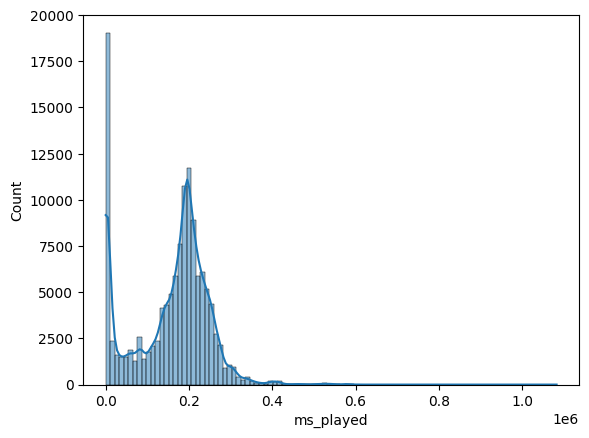

In [207]:
# histogram for ms_played rounded to nearest 1000 (in seconds) to see the distribution
sns.histplot(tracks_df['ms_played'].round(-3), kde = True, bins=100)

In [208]:
display(tracks_df[tracks_df['ms_played'] == 0].sample(5))
print(tracks_df[tracks_df['ms_played'] == 0].shape)

,ts,platform,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
40627,2019-03-05T05:57:19Z,"Android OS 9 API 28 (OnePlus, ONEPLUS A5010)",0,JP,I'm So,Andrew Applepie,Andrew Applepie,spotify:track:6gQI4RLH0RLwNMyyz8JIQ3,NaN,NaN,NaN,backbtn,backbtn,False,NaN,False,1551765435673,False
40105,2019-02-24T10:42:29Z,"Android OS 9 API 28 (OnePlus, ONEPLUS A5010)",0,JP,Friends,Hyper Potions,Friends,spotify:track:1HlumBvclGhCA2PwRlrFP5,NaN,NaN,NaN,backbtn,backbtn,True,NaN,False,1551004948220,False
24106,2018-06-09T08:32:12Z,"Android OS 8.1.0 API 27 (OnePlus, ONEPLUS A5010)",0,JP,The Fox (What Does the Fox Say?),Ylvis,The Fox (What Does the Fox Say?),spotify:track:5HOpkTTVcmZHnthgyxrIL8,NaN,NaN,NaN,backbtn,backbtn,False,NaN,False,1528533129097,False
46589,2019-06-28T06:57:02Z,"Android OS 9 API 28 (OnePlus, ONEPLUS A5010)",0,JP,"Elephant Parade - From ""Eternal Sunshine of th...",Jon Brion,Eternal Sunshine Of The Spotless Mind,spotify:track:2b40pJq5O9M2SPFwFrblqC,NaN,NaN,NaN,fwdbtn,fwdbtn,False,NaN,True,1561389369652,False
31003,2018-09-27T07:29:21Z,"Android OS 8.1.0 API 27 (OnePlus, ONEPLUS A5010)",0,JP,Immigrant Song - Remaster,Led Zeppelin,Led Zeppelin III,spotify:track:78lgmZwycJ3nzsdgmPPGNx,NaN,NaN,NaN,backbtn,backbtn,False,NaN,False,1538033360108,False


(3759, 18)


there are surprisingly a lot of rows with 0 ms_played, might need to check it later

In [209]:
# checking platform unique values
tracks_df['platform'].value_counts(dropna=False)

platform
Android OS 11 API 30 (OnePlus, HD1910)                       21563
android                                                      20780
Android OS 9 API 28 (OnePlus, ONEPLUS A5010)                 15578
Android OS 10 API 29 (OnePlus, ONEPLUS A5010)                15124
Android OS 8.1.0 API 27 (OnePlus, ONEPLUS A5010)             10919
Windows 10 (10.0.17134; x64)                                  7099
Android OS 7.1.1 API 25 (Sony, E6683)                         6847
Windows 10 (10.0.14393; x64)                                  6764
Windows 10 (10.0.18363; x64)                                  6702
Android OS 7.0 API 24 (Sony, E6683)                           4074
windows                                                       3192
Windows 10 (10.0.18362; x64)                                  2858
Android OS 8.0.0 API 26 (OnePlus, ONEPLUS A5010)              1049
Windows 10 (10.0.16299; x64)                                  1011
Android OS 6.0.1 API 23 (Sony, E6683)                

it seems there are just 3 unique values in platform column (android, windows, web_player), we need to handle this value

In [210]:
# checking the unique values in 'skipped' column, including 'NaN'
tracks_df['skipped'].value_counts(dropna=False)

skipped
NaN      105421
False     17475
0.0        3581
True       2065
1.0         851
Name: count, dtype: int64

In [211]:
# show the rows with 'skipped' value of 'NaN'
tracks_df[tracks_df['skipped'].isna()]['reason_end'].value_counts(dropna=False)

reason_end
trackdone                       62298
NaN                             20538
fwdbtn                           9239
backbtn                          4805
logout                           3845
endplay                          3118
remote                            966
unexpected-exit-while-paused      433
unexpected-exit                    64
trackerror                         63
unknown                            52
Name: count, dtype: int64

In [212]:
tracks_df[tracks_df['skipped'].isna() & tracks_df['reason_end'].isna()].sample(5)

,ts,platform,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
6848,2017-05-22T12:39:01Z,Windows 10 (10.0.14393; x64),12297,ID,Healing,In Love With a Ghost,Healing,spotify:track:0GbSslWDNItJQPA788gr20,NaN,NaN,NaN,clickrow,NaN,True,NaN,False,1495456732686,False
1891,2017-03-03T06:07:41Z,"Android OS 7.0 API 24 (Sony, E6683)",190253,ID,I'm Beginning To Think You Prefer Beverly Hill...,Fight Like Apes,Fight Like Apes and The Mystery of The Golden ...,spotify:track:0SxZpiF1BfbLiKJAamelYz,NaN,NaN,NaN,trackdone,NaN,False,NaN,False,1488516359676,False
6582,2017-05-18T10:02:38Z,"Android OS 7.0 API 24 (Sony, E6683)",0,ID,Stryman,baaskaT,Chillhop Essentials Spring 2017,spotify:track:2oFQqo6YyVeQDTpVjhUfwE,NaN,NaN,NaN,backbtn,NaN,False,NaN,False,1495101755549,False
6793,2017-05-21T12:15:38Z,"Android OS 7.0 API 24 (Sony, E6683)",132413,ID,Sorry for Not Answering the Phone I'm Too Busy...,In Love With a Ghost,Let's Go,spotify:track:3PqWJMsNn4yh9lFqBbYhuE,NaN,NaN,NaN,trackdone,NaN,True,NaN,False,1495368804196,False
9615,2017-07-26T05:35:48Z,"Android OS 7.1.1 API 25 (Sony, E6683)",270000,ID,Into the Limelight (feat. Danyka Nadeau),Trivecta,Monstercat 027 - Cataclysm,spotify:track:1Kny6fGX5BzfhI3emVgMVz,NaN,NaN,NaN,trackdone,NaN,True,NaN,False,1501047050375,False


we also need to handle 'skipped' value as it seems they are just a boolean data type and handle the NaN values

In [213]:
# checking the unique values in 'shuffle' column
tracks_df['shuffle'].value_counts(dropna=False)

shuffle
True     77246
False    52147
Name: count, dtype: int64

In [214]:
# checking the unique values in 'offline' column
tracks_df['offline'].value_counts(dropna=False)

offline
False    123422
True       5971
Name: count, dtype: int64

In [215]:
# checking the unique values in 'incognito_mode' column
tracks_df['incognito_mode'].value_counts(dropna=False)

incognito_mode
False    129076
True        317
Name: count, dtype: int64

shuffle, offline and incognito_mode's value are pretty much complete and has no NaN values, but we need to convert them into 1/0 as well

In [216]:
# checking the unique values in 'reason_start' column
print(tracks_df['reason_start'].value_counts(dropna=False))

reason_start
trackdone     96588
fwdbtn        13695
backbtn        7344
clickrow       5919
appload        4161
remote          690
playbtn         649
trackerror      347
Name: count, dtype: int64


In [217]:
# checking the unique values in 'reason_end' column
print(tracks_df['reason_end'].value_counts(dropna=False))

reason_end
trackdone                       82153
NaN                             20538
fwdbtn                          11078
backbtn                          5250
logout                           4835
endplay                          3750
remote                           1071
unexpected-exit-while-paused      533
unexpected-exit                    68
trackerror                         63
unknown                            54
Name: count, dtype: int64


based on what we've seen, there are some things that we need to handle:
- drop podcasts related columns [DONE]
- drop offline_timestamp column [DONE]
- ~~drop conn_country column since I think what _platform_ the track was streamed is more important than the _country_ it was streamed~~
- convert 'ts' column into datetime datatype [DONE]
- convert 'ts' based on the conn_country [DONE]
- rename columns with long label (master_metadata_artist_name, etc) into shorter form [DONE]
- trim spotify_track_uri to only track ids [DONE]
- handle _platform_ into three values (web_player, android, windows) [DONE]
- convert _shuffle, offline and incognito mode_ to 1 and 0 format [DONE]
- handle _skipped_ into 1 or 0 (convert True to 1, False to 0, and turn them into just integer values of 1 or 0)
- handle _skipped_'s NaN value based on _reason end_
- take a look on rows with 0 ms_played 

## Data Preprocessing

### dropping unimportant columns

In [218]:
# dropping the columns that are not useful
tracks_df.drop(columns=['offline_timestamp', 'episode_name', 'episode_show_name', 'spotify_episode_uri'], inplace=True)


### handling 'ts' and 'conn_country' column
there are some things that we need to do here:
- convert 'ts' to datetime
- check unique values of conn_country
- fix the mislabelled rows
- convert 'ts' into its proper timezone

In [219]:
# converting 'ts' to datetime format
tracks_df['ts'] = pd.to_datetime(tracks_df['ts'])

In [220]:
tracks_df['conn_country'].value_counts(dropna=False)

conn_country
JP    103209
ID     24904
SG       614
MY       334
PH       279
CA        32
US        13
ZZ         5
BV         3
Name: count, dtype: int64

it appears that conn_country are mislabelled, because I have never been to CA / US / ZZ / BV.
this mislabelling might caused by some error or because I happened to be on vpn while listening to spotify.
since the quantity of mislabelled rows are not that significant, we can just remove these rows.

but I will see if we can assign them accordingly (since the quantity is also not that many)

In [221]:
# store the date of rows with 'conn_country' value of CA, US, ZZ and BV into a list
mislabelled_conn_country_date = tracks_df[tracks_df['conn_country'].isin(['CA', 'US', 'ZZ', 'BV'])]['ts'].dt.date.unique().tolist()

In [222]:
mislabelled_conn_country_date

[datetime.date(2017, 8, 25),
 datetime.date(2017, 11, 6),
 datetime.date(2018, 7, 27),
 datetime.date(2019, 10, 22),
 datetime.date(2021, 8, 31),
 datetime.date(2021, 9, 1),
 datetime.date(2021, 11, 28),
 datetime.date(2021, 12, 2),
 datetime.date(2022, 6, 17),
 datetime.date(2022, 7, 17),
 datetime.date(2022, 8, 25),
 datetime.date(2022, 12, 10),
 datetime.date(2023, 1, 19),
 datetime.date(2023, 1, 29)]

In [223]:
# show the unique value of conn_country on each day in the list and store the most frequent value into a dictionary of date:country
conn_country_dict = {}
for date in mislabelled_conn_country_date:
    conn_country_dict[date] = tracks_df[tracks_df['ts'].dt.date == date]['conn_country'].value_counts().index[0]

In [224]:
conn_country_dict

{datetime.date(2017, 8, 25): 'ID',
 datetime.date(2017, 11, 6): 'ID',
 datetime.date(2018, 7, 27): 'JP',
 datetime.date(2019, 10, 22): 'JP',
 datetime.date(2021, 8, 31): 'JP',
 datetime.date(2021, 9, 1): 'JP',
 datetime.date(2021, 11, 28): 'JP',
 datetime.date(2021, 12, 2): 'JP',
 datetime.date(2022, 6, 17): 'JP',
 datetime.date(2022, 7, 17): 'ID',
 datetime.date(2022, 8, 25): 'JP',
 datetime.date(2022, 12, 10): 'JP',
 datetime.date(2023, 1, 19): 'JP',
 datetime.date(2023, 1, 29): 'JP'}

In [225]:
# replace the mislabelled conn_country with the correct country
tracks_df['conn_country'] = tracks_df.apply(lambda x: conn_country_dict[x['ts'].date()] if x['conn_country'] in ['CA', 'US', 'ZZ', 'BV'] else x['conn_country'], axis=1)

In [226]:
# check the unique values in 'conn_country' column again
tracks_df['conn_country'].value_counts(dropna=False)

conn_country
JP    103256
ID     24910
SG       614
MY       334
PH       279
Name: count, dtype: int64

In [242]:
# convert 'ts' from UTC to its respective conn_country timezone using pytz
import pytz
tracks_df['ts_local'] = tracks_df.apply(lambda x: x['ts'].tz_convert(pytz.timezone(pytz.country_timezones(x['conn_country'])[0])), axis=1)

In [243]:
# show 5 rows for each conn_country
for country in tracks_df['conn_country'].unique():
    print(country)
    display(tracks_df[tracks_df['conn_country'] == country][['ts', 'ts_local', 'conn_country']].sample(5))

ID


,ts,ts_local,conn_country
7672,2017-06-06 02:39:39+00:00,2017-06-06 09:39:39+07:00,ID
18036,2018-01-11 13:24:10+00:00,2018-01-11 20:24:10+07:00,ID
5840,2017-05-09 05:45:07+00:00,2017-05-09 12:45:07+07:00,ID
17283,2017-12-29 07:36:12+00:00,2017-12-29 14:36:12+07:00,ID
19842,2018-03-18 01:51:28+00:00,2018-03-18 08:51:28+07:00,ID


JP


,ts,ts_local,conn_country
66886,2020-09-28 01:35:37+00:00,2020-09-28 10:35:37+09:00,JP
103721,2022-09-15 07:36:13+00:00,2022-09-15 16:36:13+09:00,JP
109486,2023-01-09 19:10:50+00:00,2023-01-10 04:10:50+09:00,JP
116030,2023-04-30 05:05:41+00:00,2023-04-30 14:05:41+09:00,JP
123006,2023-07-23 10:19:15+00:00,2023-07-23 19:19:15+09:00,JP


MY


,ts,ts_local,conn_country
43221,2019-04-15 19:53:10+00:00,2019-04-16 03:53:10+08:00,MY
43216,2019-04-15 19:53:10+00:00,2019-04-16 03:53:10+08:00,MY
43199,2019-04-15 19:53:10+00:00,2019-04-16 03:53:10+08:00,MY
43227,2019-04-15 19:53:10+00:00,2019-04-16 03:53:10+08:00,MY
43827,2019-04-28 03:15:37+00:00,2019-04-28 11:15:37+08:00,MY


SG


,ts,ts_local,conn_country
121080,2023-06-27 01:10:08+00:00,2023-06-27 09:10:08+08:00,SG
120061,2023-06-15 23:51:35+00:00,2023-06-16 07:51:35+08:00,SG
120102,2023-06-16 23:45:28+00:00,2023-06-17 07:45:28+08:00,SG
120099,2023-06-16 23:36:56+00:00,2023-06-17 07:36:56+08:00,SG
88960,2021-12-23 19:46:40+00:00,2021-12-24 03:46:40+08:00,SG


PH


,ts,ts_local,conn_country
97307,2022-06-19 11:55:55+00:00,2022-06-19 19:55:55+08:00,PH
99827,2022-07-20 23:26:05+00:00,2022-07-21 07:26:05+08:00,PH
99825,2022-07-20 23:26:05+00:00,2022-07-21 07:26:05+08:00,PH
99881,2022-07-20 23:26:05+00:00,2022-07-21 07:26:05+08:00,PH
99883,2022-07-20 23:26:05+00:00,2022-07-21 07:26:05+08:00,PH


### renaming columns with long label

In [229]:
# renaming master_metadata_track_name, master_metadata_album_artist_name, and master_metadata_album_album_name into track_name, artist_name, and album_name
tracks_df.rename(columns={'master_metadata_track_name':'track_name', 'master_metadata_album_artist_name':'artist_name', 'master_metadata_album_album_name':'album_name'}, inplace=True)

In [230]:
tracks_df.sample(5)

,ts,platform,ms_played,conn_country,track_name,artist_name,album_name,spotify_track_uri,reason_start,reason_end,shuffle,skipped,offline,incognito_mode
5559,2017-05-07 15:34:42+07:00,Windows 10 (10.0.14393; x64),2950,ID,I Know It's Not Easy but You're Not Alone Anymore,In Love With a Ghost,Healing,spotify:track:7xRfZ4bQgEg60LQa3vgx02,fwdbtn,NaN,True,NaN,False,False
84503,2021-10-13 05:08:41+09:00,"Android OS 11 API 30 (OnePlus, HD1910)",243497,JP,drivers license,Us The Duo,drivers license,spotify:track:6i8lDXu86pOsPwGbxoD4RI,trackdone,trackdone,True,NaN,False,False
8492,2017-06-30 23:07:53+07:00,Windows 10 (10.0.14393; x64),234666,ID,We'll Be Together,In Love With a Ghost,Discography 2015-2016,spotify:track:3nhBvq3wC6zsNf23cYvXFT,trackdone,NaN,True,NaN,False,False
51731,2019-10-15 14:11:24+09:00,"Android OS 9 API 28 (OnePlus, ONEPLUS A5010)",8620,JP,Graves,CHVRCHES,Love Is Dead,spotify:track:4j1CYpZbbN26VKTby9nnet,appload,trackdone,False,NaN,False,False
40833,2019-03-09 19:31:11+09:00,"Android OS 9 API 28 (OnePlus, ONEPLUS A5010)",198800,JP,Ada Di Sana,Danilla,Telisik,spotify:track:7e3JeMmuteFbUJuUjH1RfS,trackdone,trackdone,False,NaN,False,False


### handling platform columns

In [231]:
# trim the platform values to only the first word and make it lowercase
tracks_df['platform'] = tracks_df['platform'].str.split().str[0].str.lower()

In [232]:
# replace 'partner' value in platform column with 'web_player'
tracks_df['platform'].replace('partner', 'web_player', inplace=True)

In [233]:
tracks_df['platform'].value_counts()

platform
android       97301
windows       32015
web_player       77
Name: count, dtype: int64

### handling spotify_track_uri to only track_id

In [234]:
# trim spotify_track_uri to only the track id and rename the column into track_id
tracks_df['spotify_track_uri'] = tracks_df['spotify_track_uri'].str.split(':').str[2]
tracks_df.rename(columns={'spotify_track_uri':'track_id'}, inplace=True)

In [235]:
tracks_df.sample(5)

,ts,platform,ms_played,conn_country,track_name,artist_name,album_name,track_id,reason_start,reason_end,shuffle,skipped,offline,incognito_mode
97714,2022-06-22 08:38:05+07:00,android,37293,ID,"You're Not Special, Babe",Orla Gartland,Woman on the Internet,0GaVSVifeBSwnNTNordPGC,appload,trackdone,False,NaN,False,False
114998,2023-04-14 04:59:06+09:00,android,197278,JP,Secret For The Mad,dodie,You - EP,2Uk0aFqYCtecHL5MCq2we0,trackdone,trackdone,True,False,True,False
23613,2018-06-04 10:30:08+09:00,android,2706,JP,I Miss You,Burbank,Bedroom,3LqERNkL9HK3yPmkVYFB3I,backbtn,fwdbtn,False,NaN,False,False
53071,2019-11-27 19:55:33+09:00,android,162082,JP,Haru ni yuraredo kimi omou,kobasolo,Clumsy,0o7ArBihcyH8nv4Bhfb2uM,appload,trackdone,False,NaN,False,False
91182,2022-02-01 22:41:16+09:00,android,119759,JP,(Stop) Just Love,Us The Duo,Just Love,4hGgIRtsp9nvgMCmUz0n37,trackdone,logout,True,NaN,False,False


### handling shuffle, offline and incognito mode columns

In [236]:
# convert True and False values in 'shuffle' column into 1 and 0
tracks_df['shuffle'] = tracks_df['shuffle'].astype(int)

In [237]:
# convert True and False values in 'offline' column into 1 and 0
tracks_df['offline'] = tracks_df['offline'].astype(int)

In [238]:
# convert True and False values in 'incognito_mode' column into 1 and 0
tracks_df['incognito_mode'] = tracks_df['incognito_mode'].astype(int)

### handling 'skipped' column
there are few things that we need to do here:
- convert True/False to 1/0, as well as 1.0/0.0 to 1/0
- assign NaN rows with its correct value as many as possible using reason_end and track's duration 

## saving the processed data

In [245]:
tracks_df.sample(5)

,ts,platform,ms_played,conn_country,track_name,artist_name,album_name,track_id,reason_start,reason_end,shuffle,skipped,offline,incognito_mode,ts_local
22798,2018-05-26 12:48:56+00:00,android,78720,JP,Good Morning Qt,In Love With a Ghost,Discography 2015-2016,3HO8tYJGwNdOlctYzGhzkH,trackdone,trackdone,1,NaN,0,0,2018-05-26 21:48:56+09:00
19939,2018-03-18 16:11:33+00:00,windows,223064,ID,Dragon Night,SEKAI NO OWARI,Dragon Night,24lfxhAGqFbxMWCPg23wOV,fwdbtn,NaN,1,NaN,0,0,2018-03-18 23:11:33+07:00
37337,2019-01-01 18:03:25+00:00,android,133764,JP,Baby,Bishop Briggs,Baby,21vwWfS6qvxh8TN3lgHvZr,appload,trackdone,1,NaN,0,0,2019-01-02 03:03:25+09:00
76172,2021-04-18 09:11:39+00:00,android,210917,JP,Us Against the World,Daniela Andrade,"Covers, Vol. 1",6bIOb9jMS0Fh01zTdQYfdt,trackdone,trackdone,0,NaN,0,0,2021-04-18 18:11:39+09:00
98653,2022-07-03 03:25:16+00:00,android,187185,ID,Knock Me Off My Feet,SOAK,Grim Town,3adNtom9Dn2NXmgHf0OwZR,trackdone,trackdone,0,NaN,0,0,2022-07-03 10:25:16+07:00


In [246]:
#save tracks_df into csv
tracks_df.to_csv('datasets/tracks_df_processed.csv', index=False)